In [1]:
# GBM
from gbm.data import RSP, Cspec, TTE, GbmDetectorCollection, PHA  ### 数据类
from gbm.binning.unbinned import bin_by_time  # bin_by_snr,bin_by_edges
from gbm.plot import Lightcurve, Spectrum, ModelFit  ### 画图类
from gbm.background import BackgroundFitter  ### 背景拟合类
from gbm.background.binned import Polynomial
from gbm.spectra.fitting import SpectralFitterPgstat  ### 能谱拟合类
import gbm.spectra.functions as gbm_func

# Here
from Myfuncs.my_general_utils import *
import pandas as pd
from typing import Final
import gc
import matplotlib.pyplot as plt
plt.switch_backend("Agg")
plt.rcParams["agg.path.chunksize"] = 10000

/home/tsubakura/miniconda3/envs/fermiGBM/lib/python3.9/site-packages/gbm/plot/lal_post_subs.py:184: UserWarning: Basemap not installed. Some functionality not available.
  warnings.warn('Basemap not installed. Some functionality not available.')


In [2]:
MYRSP_MATRIX: Final[str] = "generated_rsp_files"
RAWDATA: Final[str] = "Raw_Data"
SAVEPATH: Final[str] = "GBMFIT_Generated_Final"
niteration = 100000
erange_nai = (10.0, 900.0)  # keV
erange_bgo = (300.0, 35000.0)


class FitResult:
    model_symbol: dict[str, list[str]] = {
        "Band": ["A", "Ep", "alpha", "Beta"],
        "Comptonized": ["A", "Ec", "alpha"],
        "Band+BlackBody": ["A", "Ep", "alpha", "Beta", "Ab", "kT"],
        "Comptonized+BlackBody": ["A", "Ec", "alpha", "Ab", "kT"],
    }

    def __init__(self, specfitter: SpectralFitterPgstat, model_name, cl: float = 0.683):
        self.model_name: str = model_name
        self.fit_success: bool = specfitter.success
        self.message: str = specfitter.message
        self.parameters: list[float] = specfitter.parameters
        self.asyerrors: list[list[float]] = specfitter.asymmetric_errors(cl)
        self.statistics: float = specfitter.statistic
        self.dof: float = specfitter.dof

    def __repr__(self):
        indent = " " * 4
        cls = self.__class__
        cls_name = cls.__name__
        res = [f"{self.model_name} {cls_name}("]
        res.append(f"{indent}fit success: {self.fit_success}")
        res.append(f"{indent}{self.message}")
        if self.model_name in cls.model_symbol.keys():
            for symbol, val, asyerr in zip(
                cls.model_symbol[self.model_name], self.parameters, self.asyerrors
            ):
                res.append(
                    f"{indent}{symbol.ljust(10)} {val:.4f} -{asyerr[0]:.4f} + {asyerr[1]:.4f}"
                )
        res.append(f"{indent}Pgstat: {self.statistics}")
        res.append(f"{indent}dof: {self.dof}")
        res.append(")")
        return "\n".join(res)


In [3]:
grb_names = [
    "bn100619015",
    "bn121031949",
    "bn140108721",
    "bn151027166",
    "bn170514180",
    "bn171120556",
    "bn180612785",
    "bn181222279",
    "bn190419414",
]

normal_bursts = pd.read_csv("chosen_GRB_informaions.csv")
normal_bursts = (
    normal_bursts[normal_bursts.name.isin(grb_names)]
    .reset_index()
    .drop(columns=["index"])
)
grb_files = get_GRB_files(RAWDATA, grb_names)

### bn140108721 没有rsp2文件，用rsp中的 RA DEC 来选择探头数据
bn140108_rawdata = os.listdir(joinpath(RAWDATA, "bn140108721"))
bn140108_rsps_name = sorted(list(filter(lambda x: ".rsp" in x, bn140108_rawdata)))
bn140108_rsps = [
    joinpath(RAWDATA, "bn140108721", rsp_name) for rsp_name in bn140108_rsps_name
]
bn140108_dets_angles = get_dets_angles(grb_files[2].trigdat_file, bn140108_rsps[0], 60)
grb_files[2].choose_by_dets(bn140108_dets_angles)


### bn181222279 没有n5探头的tte文件
grb_files[7].dets_selection = {"b0":-1, "n4":-1}

perform the dets selection, filter the unchosen file
the GRB files are compatible
perform the dets selection, filter the unchosen file
the GRB files are compatible
the GRBfile bn140108721 does not have rsp2 files !!!
perform the dets selection, filter the unchosen file
the GRB files are compatible
perform the dets selection, filter the unchosen file
the GRB files are compatible
perform the dets selection, filter the unchosen file
the GRB files are compatible
perform the dets selection, filter the unchosen file
the GRB files are compatible
perform the dets selection, filter the unchosen file
the GRB files are incompatible
tte_files: 2	 cspec_files: 3	 rsp2_files: 3
perform the dets selection, filter the unchosen file
the GRB files are compatible
perform the dets selection, filter the unchosen file
the rsp2_files is missing


In [4]:
testgrb = grb_files[0]

In [5]:
testgrb.rsp2_files = [
    "generated_rsp_GBMpl/bn100619015/glg_cspec_b0_bn100619015_v00.rsp",
    "generated_rsp_GBMpl/bn100619015/glg_cspec_n2_bn100619015_v00.rsp",
    "generated_rsp_GBMpl/bn100619015/glg_cspec_n5_bn100619015_v00.rsp",
]

In [6]:
testgrb

GRBFIleDir(trigdat_file:Raw_Data/bn100619015/glg_trigdat_all_bn100619015_v01.fit
tte_files:['Raw_Data/bn100619015/glg_tte_b0_bn100619015_v00.fit',
 'Raw_Data/bn100619015/glg_tte_n2_bn100619015_v00.fit',
 'Raw_Data/bn100619015/glg_tte_n5_bn100619015_v00.fit']
cspec_files:['Raw_Data/bn100619015/glg_cspec_b0_bn100619015_v00.pha',
 'Raw_Data/bn100619015/glg_cspec_n2_bn100619015_v00.pha',
 'Raw_Data/bn100619015/glg_cspec_n5_bn100619015_v00.pha']
rsp2_files:['generated_rsp_GBMpl/bn100619015/glg_cspec_b0_bn100619015_v00.rsp',
 'generated_rsp_GBMpl/bn100619015/glg_cspec_n2_bn100619015_v00.rsp',
 'generated_rsp_GBMpl/bn100619015/glg_cspec_n5_bn100619015_v00.rsp'])

In [7]:
### TTE ---> Binned Data
rsp_list = [RSP.open(rsp) for rsp in testgrb.rsp2_files]
tte_list = [TTE.open(tte) for tte in testgrb.tte_files]

data_size = min(len(rsp_list), len(tte_list))
ttes = GbmDetectorCollection.from_list(tte_list[:data_size])
phaiis = GbmDetectorCollection.from_list(
    [tte.to_phaii(bin_by_time, 0.64, time_ref=0.0) for tte in ttes]
)
print(":", phaiis.detector())

: ['b0', 'n2', 'n5']


In [11]:
### RSP
rsps = GbmDetectorCollection.from_list(rsp_list[:data_size])
bkgd_range = [(-25,-5),(30,50),(160,180)]
print("Choose background: ", bkgd_range)

Choose background:  [(-25, -5), (30, 50), (160, 180)]


In [12]:
backfitters = [
    BackgroundFitter.from_phaii(phaii, Polynomial, time_ranges=bkgd_range)
    for phaii in phaiis
]
backfitters = GbmDetectorCollection.from_list(backfitters, dets=ttes.detector())
backfitters.fit(order=1)

bkgds = backfitters.interpolate_bins(
    phaiis.data()[0].tstart, phaiis.data()[0].tstop
)
bkgds = GbmDetectorCollection.from_list(bkgds, dets=ttes.detector())

### 30keV ~ 40KeV 的channel mask
chan_masks = [(i.emin < 30) | (i.emax > 40) for i in phaiis.data()]
# chan_masks = [i.emin > -1 for i in phaiis.data()]

In [13]:
########### 返回之前的src_range
src_range = (77,101)
print("src_range: ", src_range)

src_range:  (77, 101)


In [14]:
# 光变
data_lcs = phaiis.to_lightcurve(
    nai_kwargs={"energy_range": erange_nai},
    bgo_kwargs={"energy_range": erange_bgo},
)
# the energy-integrated background
bkgd_lcs = bkgds.integrate_energy(nai_args=erange_nai, bgo_args=erange_bgo)
# 源时间选择
src_lcs = phaiis.to_lightcurve(
    time_range=src_range,
    nai_kwargs={"energy_range": erange_nai},
    bgo_kwargs={"energy_range": erange_bgo},
)

# 计数谱
data_specs = phaiis.to_spectrum(time_range=src_range)
# the time-integrated background
bkgd_specs = bkgds.integrate_time(*src_range)
# 能量选择
src_specs = phaiis.to_spectrum(
    time_range=src_range,
    nai_kwargs={"energy_range": erange_nai},
    bgo_kwargs={"energy_range": erange_bgo},
)

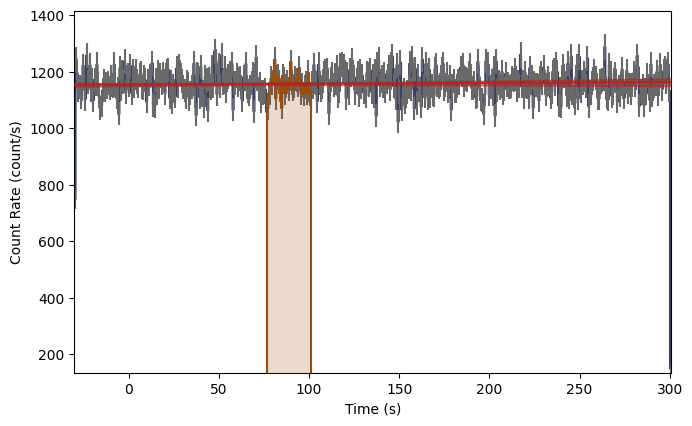

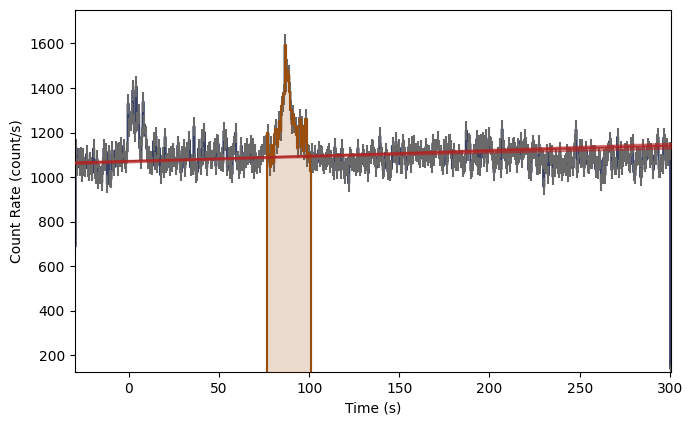

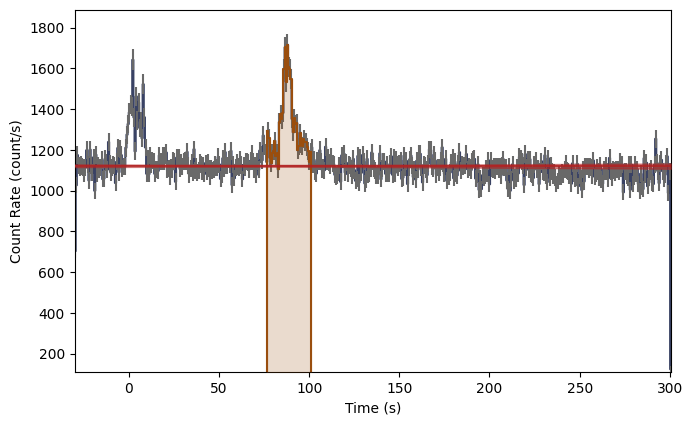

In [15]:
%matplotlib inline
lcplots = [
    Lightcurve(data=data_lc, background=bkgd_lc)
    for data_lc, bkgd_lc in zip(data_lcs, bkgd_lcs)
]
for det, src_lc, lcplot in zip(bkgds._dets, src_lcs, lcplots):
    lcplot.add_selection(src_lc)

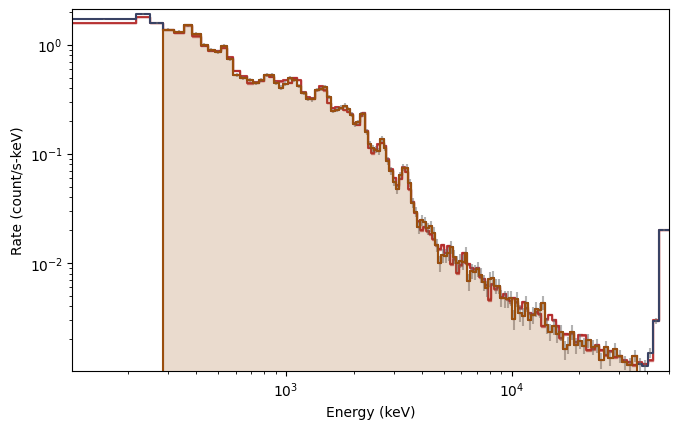

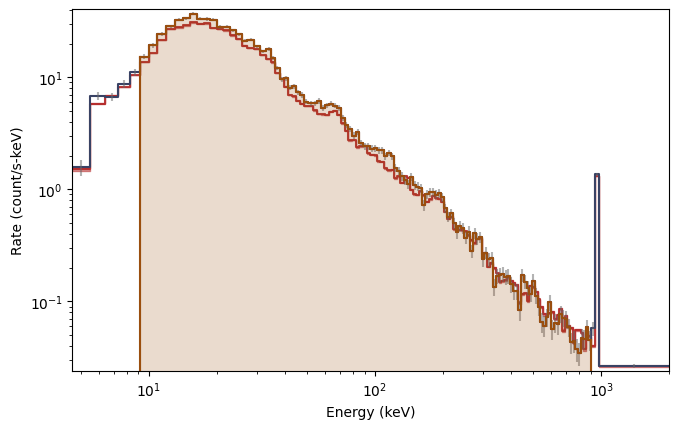

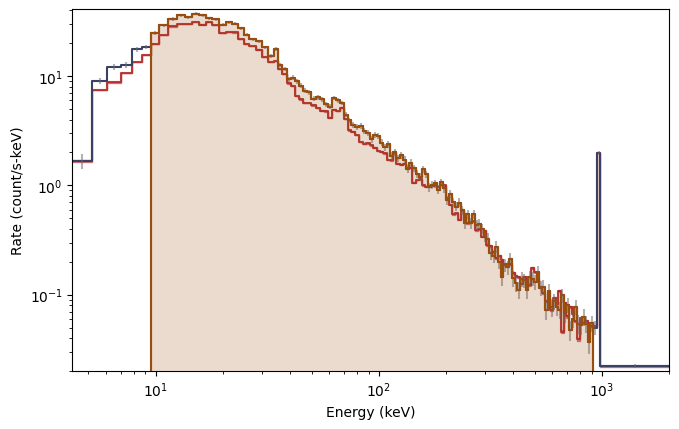

In [16]:
%matplotlib inline
specplots = [
    Spectrum(data=data_spec, background=bkgd_spec)
    for data_spec, bkgd_spec in zip(data_specs, bkgd_specs)
]
for det, src_spec, specplot in zip(bkgds._dets, src_specs, specplots):
    specplot.add_selection(src_spec)

In [17]:
### 能谱拟合
phas = phaiis.to_pha(
    time_ranges=src_range,
    nai_kwargs={"energy_range": erange_nai},
    bgo_kwargs={"energy_range": erange_bgo},
)

# interpolate response files to get DRMs at center of the source window
# rsps_interp = [rsp.interpolate(pha.tcent) for rsp, pha in zip(rsps, phas)]

# print([chan_mask for chan_mask in chan_masks])
steds = [(pha.valid_channels[0], pha.valid_channels[-1]) for pha in phas]
for chan_mask, sted in zip(chan_masks, steds):
    chan_mask[: sted[0]] = False
    chan_mask[sted[1] + 1 :] = False

In [21]:
niteration = 100000
model = gbm_func.Band()
specfitter = SpectralFitterPgstat(
    phas,
    bkgds.to_list(),
    rsps.to_list(),
    method="SLSQP",
    channel_masks=chan_masks,
)
specfitter.fit(model, options={"maxfun": niteration})
FitResult(specfitter,model.name)

/home/tsubakura/miniconda3/envs/fermiGBM/lib/python3.9/site-packages/gbm/spectra/fitting.py:292: OptimizeWarning: Unknown solver options: maxfun
  res = minimize(self._eval_stat, init_params, args=(function,),
/home/tsubakura/miniconda3/envs/fermiGBM/lib/python3.9/site-packages/gbm/spectra/fitting.py:370: UserWarning: Parameter exists at its lower bound
  warnings.warn("Parameter exists at its lower bound")


Band FitResult(
    fit success: True
    Optimization terminated successfully
    A          0.0100 -0.0100 + 0.0000
    Ep         500.0000 -499.9900 + 0.7520
    alpha      -0.5000 -1.0699 + 0.0032
    Beta       -2.5000 -7.5000 + 0.0328
    Pgstat: 1168.066883321763
    dof: 346
)

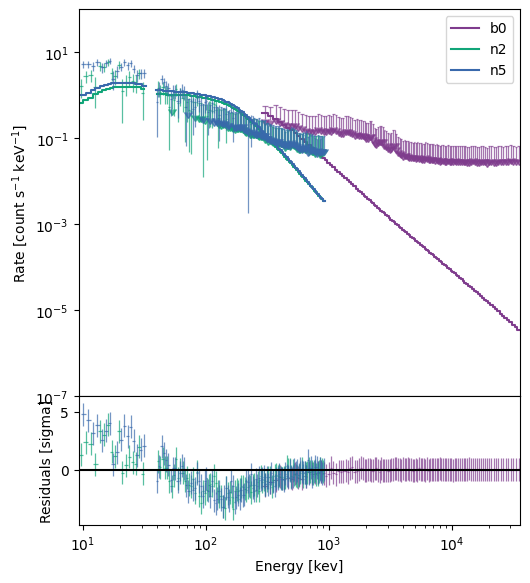

In [22]:
%matplotlib inline
modelplot_1 = ModelFit(fitter=specfitter)
modelplot_1.ax.set_ylim(1e-7, 100)
modelplot_1

/home/tsubakura/miniconda3/envs/fermiGBM/lib/python3.9/site-packages/gbm/spectra/fitting.py:600: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  samples = multivariate_normal(self.parameters, self.covariance,


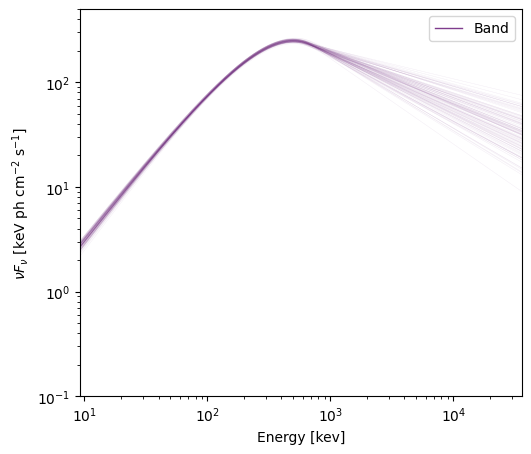

In [28]:
modelplot_2 = ModelFit(fitter=specfitter, view="nufnu")
modelplot_2.ax.set_ylim(1e-1, 500)
modelplot_2

In [43]:
niteration = 100000
model = gbm_func.Band()+gbm_func.BlackBody()
model.default_values = [0.01,200,-1.0,-2.2,100.0,0.0001,10]
specfitter = SpectralFitterPgstat(
    phas,
    bkgds.to_list(),
    rsps.to_list(),
    method="SLSQP",
    channel_masks=chan_masks,
)
specfitter.fit(model, options={"maxfun": niteration})
FitResult(specfitter,model.name)

/home/tsubakura/miniconda3/envs/fermiGBM/lib/python3.9/site-packages/gbm/spectra/functions.py:903: RuntimeWarning: overflow encountered in exp
  fxn = A * x ** 2 / (np.exp(x / kT) - 1.0)
/home/tsubakura/miniconda3/envs/fermiGBM/lib/python3.9/site-packages/scipy/optimize/_slsqp_py.py:437: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  fx = wrapped_fun(x)


Band+BlackBody FitResult(
    fit success: True
    Optimization terminated successfully
    A          0.0057 -0.0006 + 0.0008
    Ep         199.3527 -51.8362 + 21.9593
    alpha      -0.9685 -0.1608 + 0.1040
    Beta       -4.5910 -5.4090 + 2.2009
    Ab         0.0014 -0.0002 + 0.0002
    kT         7.3415 -0.4385 + 0.3289
    Pgstat: 285.4364649901445
    dof: 344
)

/home/tsubakura/miniconda3/envs/fermiGBM/lib/python3.9/site-packages/gbm/spectra/functions.py:903: RuntimeWarning: overflow encountered in exp
  fxn = A * x ** 2 / (np.exp(x / kT) - 1.0)


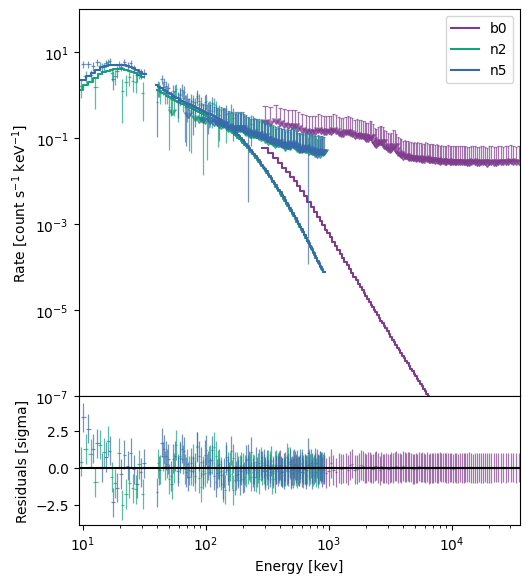

In [44]:
%matplotlib inline
modelplot_1 = ModelFit(fitter=specfitter)
modelplot_1.ax.set_ylim(1e-7, 100)
modelplot_1

/home/tsubakura/miniconda3/envs/fermiGBM/lib/python3.9/site-packages/gbm/spectra/functions.py:903: RuntimeWarning: overflow encountered in exp
  fxn = A * x ** 2 / (np.exp(x / kT) - 1.0)
/home/tsubakura/miniconda3/envs/fermiGBM/lib/python3.9/site-packages/gbm/spectra/fitting.py:600: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  samples = multivariate_normal(self.parameters, self.covariance,


Residuals already hidden


/home/tsubakura/miniconda3/envs/fermiGBM/lib/python3.9/site-packages/gbm/spectra/functions.py:903: RuntimeWarning: overflow encountered in exp
  fxn = A * x ** 2 / (np.exp(x / kT) - 1.0)
/home/tsubakura/miniconda3/envs/fermiGBM/lib/python3.9/site-packages/gbm/spectra/fitting.py:600: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  samples = multivariate_normal(self.parameters, self.covariance,


(1e-07, 10)

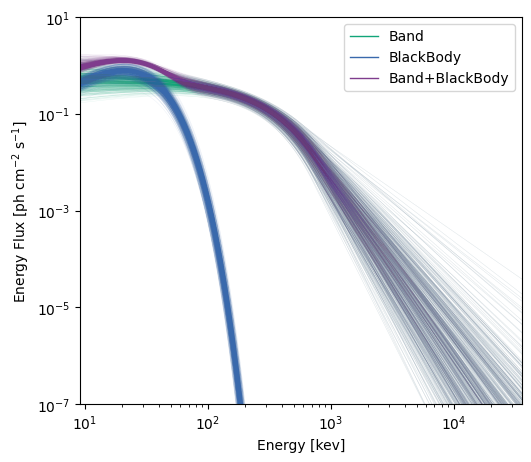

In [54]:
modelplot_2 = ModelFit(fitter=specfitter, view="nufnu")
modelplot_2.energy_spectrum(num_samples=500)
modelplot_2.ax.set_ylim(1e-7, 10)

In [48]:
modelplot_2